<a href="https://colab.research.google.com/github/Anik85/Anik85/blob/main/ECG_inception_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d shayanfazeli/heartbeat

 99% 98.0M/98.8M [00:05<00:00, 22.1MB/s]
100% 98.8M/98.8M [00:05<00:00, 18.3MB/s]


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/heartbeat.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight, resample
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Input,  Softmax, Add,  AveragePooling1D, ZeroPadding1D,Activation
from keras import backend as K
from keras.models import Model
from keras.initializers import glorot_uniform

In [5]:
train_df=pd.read_csv('/content/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/mitbih_test.csv',header=None)

In [6]:
train_df.shape

(87554, 188)

In [7]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
test_df.shape

(21892, 188)

In [9]:
train_df.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64

In [10]:
print(train_df[187].value_counts())

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64


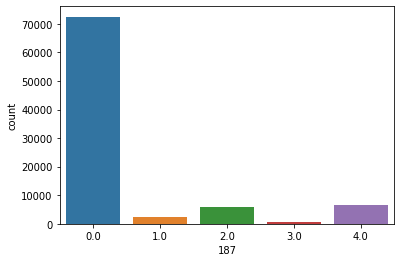

In [11]:
sns.countplot(x=187, data = train_df) 

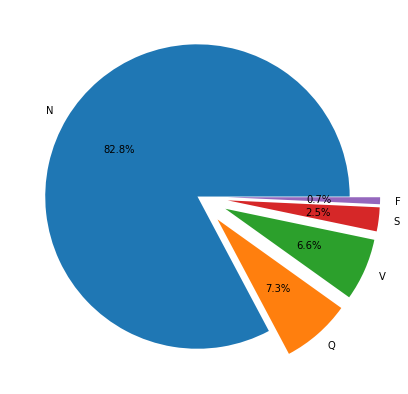

In [12]:
plt.figure(figsize=(7,7))
explode = (0, 0.2,0.2,0.2,0.2)
plt.pie(train_df[187].value_counts(), labels=['N','Q','V','S','F'], autopct='%1.1f%%', explode=explode)
plt.show()

In [13]:
x = train_df.drop(187,axis=1)
y = train_df[187].astype('int64')
print(x.shape)
print(y.shape)

#x_test = test_df.drop(187,axis=1)
#y_test = test_df[187].astype('int64')
#print(x_test.shape)
#print(y_test.shape)

(87554, 187)
(87554,)


In [14]:
x_train,x_val,y_train,y_val = train_test_split(x,y.values,random_state=42,stratify=y.values,shuffle=True,train_size=0.75)

In [15]:
print("The shape of training data : ",x_train.shape,y_train.shape)
print("The shape of validation data : ",x_val.shape,y_val.shape)

The shape of training data :  (65665, 187) (65665,)
The shape of validation data :  (21889, 187) (21889,)


In [16]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
#x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [17]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
#y_test = tf.keras.utils.to_categorical(y_test)

In [18]:
x_train = np.expand_dims(x_train, 2)
x_val = np.expand_dims(x_val, 2)
#x_test = np.expand_dims(x_test, 2)
print("The shape of training data : ",x_train.shape,y_train.shape)
print("The shape of validation data : ",x_val.shape,y_val.shape)
#print("The shape of testing data : ",x_test.shape,y_test.shape)

The shape of training data :  (65665, 187, 1) (65665, 5)
The shape of validation data :  (21889, 187, 1) (21889, 5)


In [19]:
Classes_index = {
    'N': 0, 
    'S': 1, 
    'V': 2, 
    'F': 3, 
    'Q': 4
}

In [33]:
import keras
class Classifier_INCEPTION:
    def __init__(self, weights_directory, input_shape, nb_classes, verbose=False, build=True, batch_size=64,
                 nb_filters=32, use_residual=True, use_bottleneck=True, depth=10, kernel_size=41, nb_epochs=20):
        self.weights_directory = weights_directory
        self.nb_filters = nb_filters
        self.use_residual = use_residual
        self.use_bottleneck = use_bottleneck
        self.depth = depth
        self.kernel_size = kernel_size - 1
        self.callbacks = None
        self.batch_size = batch_size
        self.bottleneck_size = 32
        self.nb_epochs = nb_epochs

        if build == True:
            self.model = self.build_model(input_shape, nb_classes)
            if (verbose == True):
                self.model.summary()
            self.verbose = verbose

    def _inception_module(self, input_tensor, stride=1, activation='linear'):

        if self.use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = Conv1D(filters=self.bottleneck_size, kernel_size=1,
                                     padding='same', activation=activation, use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        kernel_size_s = [self.kernel_size // (2 ** i) for i in range(3)]

        conv_list = []

        for i in range(len(kernel_size_s)):
            conv_list.append(Conv1D(filters=self.nb_filters, kernel_size=kernel_size_s[i],
                                    strides=stride, padding='same', activation=activation, use_bias=False)(
                input_inception))

        max_pool_1 = MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_6 = Conv1D(filters=self.nb_filters, kernel_size=1,
                        padding='same', activation=activation, use_bias=False)(max_pool_1)

        conv_list.append(conv_6)

        x = Concatenate(axis=2)(conv_list)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        return x

    def _shortcut_layer(self, input_tensor, out_tensor):
        shortcut_y = Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                            padding='same', use_bias=False)(input_tensor)
        shortcut_y = BatchNormalization()(shortcut_y)

        x = Add()([shortcut_y, out_tensor])
        x = Activation('relu')(x)
        return x

    def build_model(self, input_shape, nb_classes):
        input_layer = Input(input_shape)

        x = input_layer
        input_res = input_layer

        for d in range(self.depth):

            x = self._inception_module(x)

            if self.use_residual and d % 3 == 2:
                x = self._shortcut_layer(input_res, x)
                input_res = x

        gap_layer = GlobalAveragePooling1D()(x)

        output_layer = Dense(nb_classes, activation='softmax')(gap_layer)

        model = Model(inputs=input_layer, outputs=output_layer)

        model.compile(loss='categorical_crossentropy', 
                      optimizer=Adam(),
                      metrics=['accuracy', Precision(), Recall()])

        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                      factor=0.5, 
                                      patience=int(self.nb_epochs/20),
                                      min_lr=0.0001)
        
        file_path = os.path.join(self.weights_directory,"best_weights.h5")
        model_checkpoint = ModelCheckpoint(filepath=file_path, 
                                           monitor='val_accuracy',
                                           mode="max",
                                           save_best_only=True)
        
        early_stopping = EarlyStopping(monitor="val_accuracy", 
                                       mode="max", 
                                       verbose=1, 
                                       patience=int(self.nb_epochs/10))
        plotlosses = PlotLossesKeras()
        self.callbacks = [reduce_lr, model_checkpoint, early_stopping,plotlosses]
        return model

    def fit(self, x_train, y_train, x_val, y_val, class_weights=None):       
        if self.batch_size is None:
            mini_batch_size = int(min(x_train.shape[0] / 10, 16))
        else:
            mini_batch_size = self.batch_size

        start_time = time.time()
        hist = self.model.fit(x_train, y_train, 
                              batch_size=mini_batch_size, 
                              epochs=self.nb_epochs,
                              verbose=self.verbose, 
                              validation_data=(x_val, y_val), 
                              callbacks=self.callbacks)
        
        duration = time.time() - start_time
        keras.backend.clear_session()
        print("Model take {} S to train ".format(duration))
        return hist 

In [34]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
from keras.layers import Activation,Input,Concatenate, Add, \
                         GlobalAveragePooling1D,MaxPool1D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

weights_directory = "./"
inception = Classifier_INCEPTION(weights_directory, x_train.shape[1:], len(Classes_index.keys()), 1, 
                                 batch_size=256, build=True)



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 max_pooling1d_20 (MaxPooling1D  (None, 187, 1)      0           ['input_4[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_107 (Conv1D)            (None, 187, 32)      1280        ['input_4[0][0]']                
                                                                                                  
 conv1d_108 (Conv1D)            (None, 187, 32)      640         ['input_4[0][0]']          

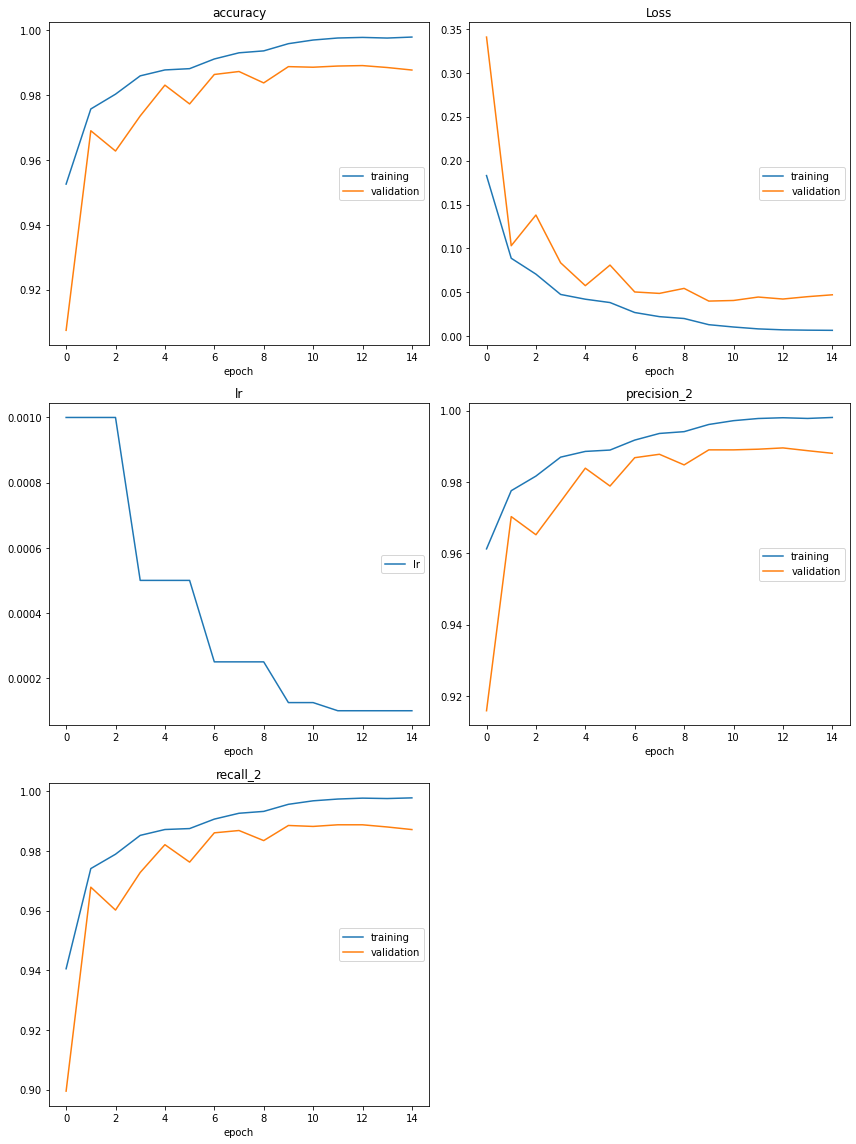

accuracy
	training         	 (min:    0.953, max:    0.998, cur:    0.998)
	validation       	 (min:    0.907, max:    0.989, cur:    0.988)
Loss
	training         	 (min:    0.007, max:    0.183, cur:    0.007)
	validation       	 (min:    0.040, max:    0.341, cur:    0.047)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
precision_2
	training         	 (min:    0.961, max:    0.998, cur:    0.998)
	validation       	 (min:    0.916, max:    0.990, cur:    0.988)
recall_2
	training         	 (min:    0.941, max:    0.998, cur:    0.998)
	validation       	 (min:    0.899, max:    0.989, cur:    0.987)
257/257 [==============================] - 52s 202ms/step - loss: 0.0068 - accuracy: 0.9979 - precision_2: 0.9981 - recall_2: 0.9978 - val_loss: 0.0473 - val_accuracy: 0.9878 - val_precision_2: 0.9880 - val_recall_2: 0.9872 - lr: 1.0000e-04
Epoch 15: early stopping
Model take 789.4181535243988 S to train 


In [36]:
import time
history = inception.fit(x_train, y_train, x_val, y_val)

In [37]:
inception.model.load_weights("./best_weights.h5")

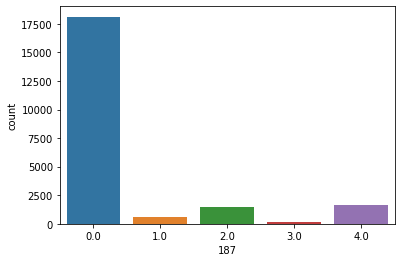

In [38]:
classes = []
sns.countplot(x=187, data = test_df)

In [39]:
print(test_df[187].value_counts())

0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64


In [40]:
class_1 = test_df[test_df[187]==1.0]
class_2 = test_df[test_df[187]==2.0]
class_3 = test_df[test_df[187]==3.0]
class_4 = test_df[test_df[187]==4.0]
class_0 = test_df[test_df[187]==0.0].sample(n = 1400)

class_1=resample(class_1, replace=True, n_samples=600, random_state=1)
#class_2=resample(class_2, replace=True, n_samples=2000, random_state=1)
class_3=resample(class_3, replace=True, n_samples=500, random_state=1)
#class_4=resample(class_4, replace=True, n_samples=2000, random_state=1)

In [41]:
new_test_df = pd.concat([class_0, class_1, class_2, class_3, class_4])

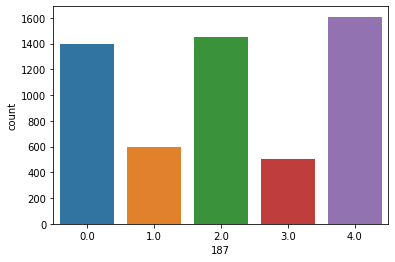

In [42]:
sns.countplot(x=187, data = new_test_df) 

In [43]:
x_test = new_test_df.drop(187,axis=1)
y_test = new_test_df[187].astype('int64')
print(x_test.shape)
print(y_test.shape)

(5556, 187)
(5556,)


In [44]:
x_test = scaler.transform(x_test)

In [45]:
y_test = tf.keras.utils.to_categorical(y_test)

In [46]:
x_test = np.expand_dims(x_test, 2)
print("The shape of testing data : ",x_test.shape,y_test.shape)

The shape of testing data :  (5556, 187, 1) (5556, 5)


In [47]:
inception.model.evaluate(x_test, y_test)

174/174 [==============================] - 3s 13ms/step - loss: 0.2041 - accuracy: 0.9512 - precision_2: 0.9537 - recall_2: 0.9501


[0.20414333045482635,
 0.9512239098548889,
 0.953748881816864,
 0.9501439929008484]

Text(0, 0.5, 'accuracy')

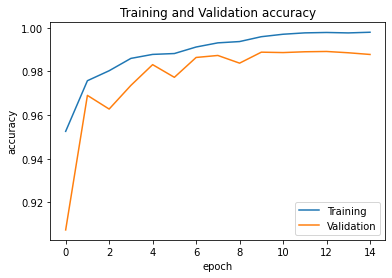

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

Text(0, 0.5, 'loss')

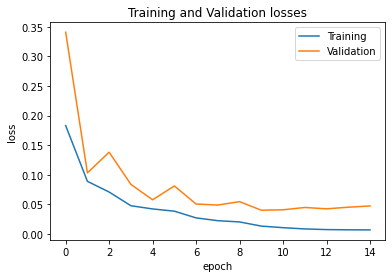

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')

174/174 [==============================] - 5s 16ms/step


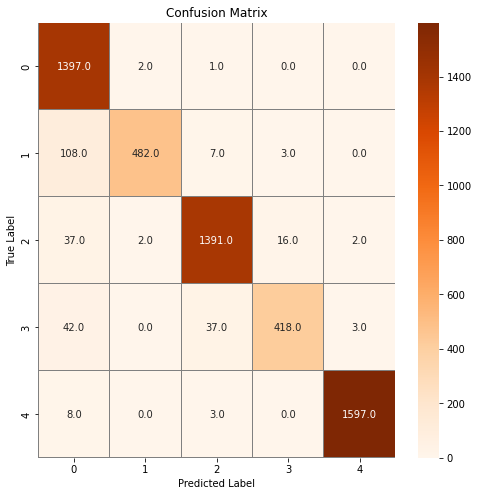

In [52]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

Y_pred = inception.model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [53]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1400
           1       0.99      0.80      0.89       600
           2       0.97      0.96      0.96      1448
           3       0.96      0.84      0.89       500
           4       1.00      0.99      1.00      1608

    accuracy                           0.95      5556
   macro avg       0.96      0.92      0.93      5556
weighted avg       0.95      0.95      0.95      5556

